In [1]:
%autosave 300
%matplotlib inline
import matplotlib.pyplot as plt
from hidden import *       # Функции, реалзация которых не особо интересна в свете этой темы
from answers import *      # Ответы
from visual_utils import * # Функции визуализации

Autosaving every 300 seconds


## Триангуляция $y$-монотонного многоугольника

<img src="illust/funnel1.svg" width=200 height=300 style="float: right;" />
Рассмотрим $P$ - $y$-монотонный многоугольник. Когда мы идём по левой или правой его границе, мы всегда спускаемся вниз (ещё мы можем двигаться горизонтально, но с заданным нами порядком на точках это неважно). Поэтому мы можем применить жадный алгоритм: будем проходить сверху вниз по вершинам многоугольника, добавляя диагонали где только возможно.


Обрабатываем вершины, как и раньше, от меньшей к большей. Будем поддерживать стек $S$ - вершины $P$, которые мы уже прошли, но к которым по-прежнему можно добавить диагонали, т.е. они находятся в нетриангулированной части $P$. На вершине стека будет лежать точка, обработанная предыдущей, т.е. самая нижняя. Когда мы обрабатываем очередную вершину $v$ (красная на рис. 1), будем пытаться провести как можно больше диагоналей из неё в вершины на стеке (жёлтые на рис. 1).<br>
Можно заметить, что та часть $P$, которая ещё не триангулирована и лежит выше текущей вершины, имеет форму перевёрнутой воронки. Одна сторона воронки состоит из одной из сторон $P$, а другая состоит из цепи вершин, которые лежат выше $v$, и внутренние углы которых не меньше чем $\pi$. Единственная выпуклая вершина лежит на дне стека. Воронка образуется как раз из-за внутренних углов: если бы они были меньше $\pi$, мы бы провели между вершинами стека диагонали на предыдущих шагах. Несложно догадаться, что это свойство сохраняется после обработки вершины и образует инвариант алгоритма.

*Какой-то монотонный многоугольник $P$*

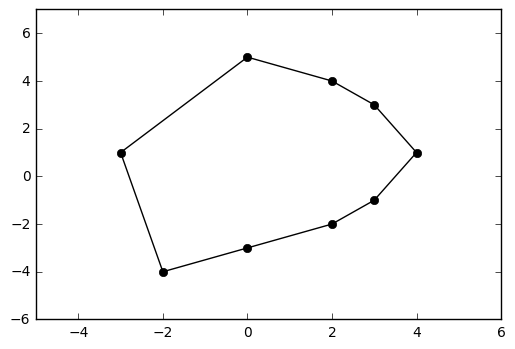

In [2]:
#source = [(4,0),(5,2),(3,3),(0,7),(-3,5),(-4,3),(-6,2),(-3,-1)]
source = [(4,1),(3,3),(2,4),(0,5),(-3,1),(-2,-4),(0,-3),(2,-2),(3,-1)]
source = list(map(lambda i: Vertex(i[0],i[1]), source))
draw_points(source)

In [3]:
Q = list(sorted(source)) # Очередь вершин
D = build_dcel(source)   # Исходный многоугольник в формате DCEL
D1 = []  # Добавленные диагонали будем хранить в отдельном списке для наглядной визуализации
S = []   # Стек вершин

# Визуализация
c = 0 
folder = 'triang' 
os.makedirs(folder, exist_ok=True)
def dump(v):
    global c
    visual_dump_triang(v,D,D1,S,Q,os.path.join(folder,'{}.png'.format(c)))
    c += 1

Теперь рассмотрим более подробно процесс того, как мы будем проводить диагонали. Нам необходимо различать два случая: текущая вершина $v_j$ лежит на той же стороне многоугольника, что и вершины в стеке, или нет.

#### Задание 2 - определение цепочек

Дополните функцию:

In [4]:
def different_chains(v1, v2):
    """Определяет, находятся ли вершины v1 и v2 
    на одной цепочке (стороне) многоугольника.
    v1 и v2 имеют тип Vertex, из них можно извлечь h1 и h2 - 
    соответствующие half-edge.
    Требуется вернуть True, если вершины находятся на разных сторонах 
    многоугольника, и False иначе.
    """
    h1 = v1.hedgelist[1]
    h2 = v2.hedgelist[1]
    return different_chains_answer(h1, h2) # Заглушка с функцией-ответом на задачу

#### $v_j$ и вершина стека лежат на разных сторонах.

Тогда $v_j$ - это нижняя граница ребра $e$, которое в свою очередь является границей воронки. Мы можем добавить диагонали ко всем вершинам на стеке, кроме самой глубокой: она и так соединена с $v_j$ ребром $e$. Все они будут удалены из стека (рис. 2). Нетриангулированная часть $P$ теперь ограничена ребром, соединяющим $v_j$ и $v_s$ - бывшей вершиной стека. Ребро, выходящее из $v_j$, направлено вниз, и инвариант воронки сохраняется. Вершины $v_j$ и $v_s$ остаются видимыми из нетриангулированной части $P$, поэтому они кладутся на стек.



In [5]:
def handle_different(j):
    while len(S) > 0:
        if len(S) != 1:
            top = S.pop()
            D1.append(add_diagonal(Q[j].hedgelist[1],top.hedgelist[1]))
            dump(Q[j])
        else:
            S.pop()
    S.append(Q[j-1])
    S.append(Q[j])
    dump(Q[j])

*На рисунке: красная вершина - текущая ($v_j$), $v_s$ - вершина стека, зелёные вершины - к которым мы можем и провели диагонали, жёлтая - к которой нельзя провести диагональ и на которой окончилось извлечение из стека.*
<img src="illust/funnel2.svg?1"/>

#### $v_j$ и вершина стека лежат в одной цепочке.
В этом случае нам может не удасться провести диагонали ко всем вершинам на стеке, но мы будем пытаться. Сначала снимем одну вершину со стека - они и так соединена с $v_j$ ребром. Затем будем проводить диагонали, пока можем. Проверять это мы будем с помощью предиката поворота от $v_j$, последней снятой со стека точке, и точке на вершине стека (к которой мы и пытаемся провести диагональ). Как только мы находим точку, с которой нельзя соединить нашу, мы кладём последнюю вынутую вершину обратно на стек. Она может оказаться либо последней вершиной, до которой удалось провести диагональ (рис. 3а), либо соседом $v_j$, если ни одну провести не удалось (рис. 3б). Затем кладём на стек $v_j$, восстанавливая инвариант.

In [6]:
def handle_same(j):
    last = S.pop()
    while len(S) > 0 and turn(Q[j], last, S[-1]) > 0:
        last = S.pop()
        D1.append(add_diagonal(Q[j].hedgelist[1], last.hedgelist[1]))
        dump(Q[j])
    S.append(last)
    S.append(Q[j])
    dump(Q[j])

Кладём первые две вершины на стек и обходим все оставшиеся, кроме последней:

In [7]:
S.append(Q[0])
S.append(Q[1])

for j in range(2, len(Q) - 1):
    dump(Q[j])
    if different_chains(Q[j],S[-1]):
        handle_different(j)
    else:
        handle_same(j)

Чтобы завершить алгоритм, нам надо соединить последнюю в очереди вершину, со всем вершинами, оставшимися на стеке, кроме первой и последней:

In [8]:
S.pop()
while len(S) > 0:
    if len(S) != 1:
        top = S.pop()
        D1.append(add_diagonal(Q[-1].hedgelist[1],top.hedgelist[1]))
        dump(Q[-1])
    else:
        S.pop()

dump(None)

Виджет ниже позволяет посмотреть работу алгоритма по шагам. Красным обозначена текущая точка, чёрным - уже обработанные, жёлтым - точки в стеке. Диагонали проведены пунктирами.  

In [9]:
from IPython.display import display
display(SlideShower(folder))

### Доказательство корректности и оценка асимптотики

Доказательство корректности алгоритма достаточно легко вывести из его построения - построенные диагонали попарно не пересекаются, потому что мы на каждом шаге проводим их только в нетриангулированной части многоугольника, диагонали проводятся ко всем вершинам, кроме соседних.

Главный цикл `for` выолняется $N - 3$ раза. Заметим, что на каждой его итерации в стек кладутся максимум две вершины, значит общее количество операций `push`, включая первые две, равно $2N - 4$. Операций `pop` не может быть больше, чем `push`, поэтому весь цикл и соединение последней вершины с оставшимися работают за $O(N)$.

### Общая оценка

Разбиение многоугольника на части занимает $O(NlogN)$ времени и $O(N)$ памяти. Суммарное количество вершин во всех частях $O(N)$, триангуляция занимает линейное время и память, поэтому вторая часть алгоритма суммарно работает за $O(N)$. Получаем следующий результат:

> Многоугольник c $N$ вершинами может быть триангулирован алгоритмом, использующим $O(NlogN)$ времени и $O(N)$ памяти.